In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from time import time
from scipy.ndimage.measurements import label
from mpl_toolkits.mplot3d import Axes3D
from moviepy.editor import VideoFileClip

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
cars = list(glob.iglob('./data/vehicles/**/*.png', recursive=True))
notcars = list(glob.iglob('./data/non-vehicles/**/*.png', recursive=True))

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [5]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [6]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [7]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (16, 16) #(32, 32)
orient = 11 # 9
pix_per_cell = 16 # 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
# spatial_size = (16, 16)
hist_bins = 64 # 32

spatial_feat=True
hist_feat=True
hog_feat=True

spatial_feat = True  
hist_feat = True  
hog_feat = True 
#     y_start_stop = [390, 710] 

t = time()

# def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
#                         hist_bins=32, orient=9, 
#                         pix_per_cell=8, cell_per_block=2, hog_channel=0,
#                         spatial_feat=True, hist_feat=True, hog_feat=True):


# def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
#                         hist_bins=32, orient=9, 
#                         pix_per_cell=8, cell_per_block=2, hog_channel=0,
#                         spatial_feat=True, hist_feat=True, hog_feat=True):

car_features = extract_features(imgs=cars, 
                                color_space=color_space, 
                                spatial_size=spatial_size,
                                hist_bins=hist_bins,
                                orient=orient,
                                pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel,
                                spatial_feat=spatial_feat,
                                hist_feat=hist_feat,
                                hog_feat=hog_feat)
  
notcar_features = extract_features(imgs=notcars, 
                                color_space=color_space, 
                                spatial_size=spatial_size,
                                hist_bins=hist_bins,
                                orient=orient,
                                pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel,
                                spatial_feat=spatial_feat,
                                hist_feat=hist_feat,
                                hog_feat=hog_feat)    
    
# car_features = extract_features(imgs=cars, color_space=color_space, orient=orient, 
#                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel,
#                         spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat

# notcar_features = extract_features(notcars, color_space=colorspace, orient=orient, 
#                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel,
#                         spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time()
print(round(t2-t, 2), 'Seconds to extract features...')

60.28 Seconds to extract features...


In [8]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = 42
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

In [9]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
# penalty='l2', default loss, dual=True, C=0.001, accuracy=0.993

# accuracy = 0.993
svc = LinearSVC(random_state=42, penalty='l2', C=0.001, loss='squared_hinge', dual=True)

# accuracy = 0.9913
# svc = LinearSVC(random_state=42, penalty='l1', C=0.1, loss='squared_hinge', dual=False)

# accuracy = 0.9969
# svc = SVC(kernel='rbf', C=1.0, random_state=42)
# 
# Check the training time for the SVC
t = time()
svc.fit(X_train, y_train)
t2 = time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t = time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2148
1.5 Seconds to train SVC...
Test Accuracy of SVC =  0.989
My SVC predicts:  [ 0.  0.  0.  1.  1.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  1.  1.  1.  0.  0.  0.]
0.00247 Seconds to predict 10 labels with SVC


In [10]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [11]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [12]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [13]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(
    img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,
    cell_per_block, spatial_size, hist_bins,
    # Instead of overlap, define how many cells to step
    cells_per_step = 2,
    dec_threshold = 0.0
):
    
    draw_img = np.copy(img)
#     img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            dec = svc.decision_function(test_features)
            
            if test_prediction == 1 and dec > dec_threshold:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                ybox_top = ytop_draw + ystart
                win_draw = np.int(window*scale)
                xbox_right = xbox_left+win_draw
                ybox_bottom = ytop_draw+win_draw+ystart
                bboxes.append(((xbox_left, ybox_top), (xbox_right, ybox_bottom)))
                
    return bboxes
                
                
#                 ytop_draw = np.int(ytop*scale)
                
#                 win_draw = np.int(window*scale)
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
            
#             if test_prediction == 1:
#                 xbox_left = np.int(xleft*scale)
#                 ytop_draw = np.int(ytop*scale)
#                 win_draw = np.int(window*scale)
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
#     return draw_img

In [27]:
# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    # 1) Create an empty list to receive positive detection windows
    on_windows = []
    # 2) Iterate over all windows in the list
    for window in windows:
        # 3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))

        # plt.imshow(test_img)
        # plt.show()
        # 4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        # 5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # 6) Predict using your classifier
        # print test_features
        prediction = clf.predict(test_features)
        # print prediction
        # 7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # 8) Return windows for positive detections
    return on_windows

In [35]:
global bbox_memory = []

SyntaxError: invalid syntax (<ipython-input-35-c929cf83ab92>, line 1)

In [50]:
def process_image(image):
    global bbox_memory
    orig_img = np.copy(image)

    image = image.astype(np.float32) / 255
    draw_image = np.copy(image)

    heat = np.zeros_like(draw_image[:, :, 0]).astype(np.float)

    # create sliding windows
    windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 640],
                            xy_window= (128, 128), xy_overlap=(0.5, 0.5))

    windows2 = slide_window(image, x_start_stop=[32, None], y_start_stop=[400, 600],
                            xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    windows3 = slide_window(image, x_start_stop=[412, 1280], y_start_stop=[390, 540],
                            xy_window=(80, 80), xy_overlap=(0.5, 0.5))

    windows = windows1 + windows2 + windows3

    # windows_on_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)
    # plt.imshow(windows_on_img)
    # plt.show()


    hot_windows = search_windows(draw_image, windows, svc, X_scaler, color_space=color_space,
                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                 orient=orient, pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,
                                 hog_channel=hog_channel, spatial_feat=spatial_feat,
                                 hist_feat=hist_feat, hog_feat=hog_feat)


    # window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    #
    # plt.imshow(window_img)
    # plt.show()

    # don't detect anything until memory is full
    if len(bbox_memory) < 30:
        bbox_memory.append(hot_windows) #appendleft(hot_windows)

        return draw_image

    else:

        # forget oldest bounding boxes
#         bbox_memory.pop()
        bbox_memory = bbox_memory[1:]
        # add newest bounding boxes
        bbox_memory.append(hot_windows)

        previous_bboxes = []

        for bbox in bbox_memory:
            previous_bboxes.extend(bbox)

        # get heatmap from bounding boxes found in previous frames
        heat = add_heat(heat, previous_bboxes)
        # theshold to remove false positives
        heat = apply_threshold(heat, 9.0)
        heatmap = np.clip(heat, 0, 255)

        labels = label(heatmap)

        labelled_image = draw_labeled_bboxes(orig_img, labels)

        # plt.imshow(window_img)
        # plt.show()
        # #
        # plt.imshow(heatmap)
        # plt.show()
        # #
        # #
        # plt.imshow(labelled_image)
        # plt.show()

        return labelled_image

In [19]:
y_max, x_max, _ = np.shape(image)
ystart = int(0.5 * y_max)
ystop = y_max

svc = svc # rbf_svc # linear_svc

scale = 2.0

draw_image = np.copy(image)

# hot_windows = find_cars(
#     draw_image, ystart, ystop, scale, svc, X_scaler, orient, 
#     pix_per_cell, cell_per_block, spatial_size, hist_bins,
#     cells_per_step = 2
# )

# window_img = draw_boxes(draw_image, hot_windows, color=(0, 255, 0), thick=6) 
window_img = process_image(draw_image)

plt.imshow(window_img)
plt.show()

NameError: name 'image' is not defined

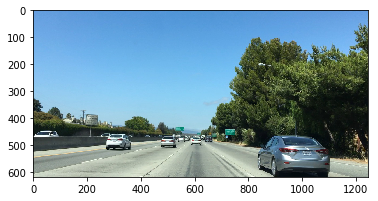

In [50]:
plt.imshow(image)
plt.show()

In [20]:
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
# image = image.astype(np.float32)/255

In [21]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [22]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [40]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], color=(0,255,0), thickness=6)
    # Return the image
    return img

In [41]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

image2 = np.copy(image)

ystart = int(0.3 * y_max) #int(0.7 * y_max)
box_list = []
for scale in [1.0, 1.2, 1.6]:
    boxes = find_cars(
        draw_image, ystart, ystop, scale, svc, X_scaler, orient, 
        pix_per_cell, cell_per_block, spatial_size, hist_bins,
        cells_per_step = 2
    )
    box_list.extend(boxes)

# box_list = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                         hist_feat=hist_feat, hog_feat=hog_feat)   


# Add heat to each box in box list
heat = add_heat(heat, box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

NameError: name 'image' is not defined

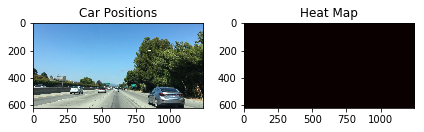

In [56]:
fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()

In [24]:
class Pipeline:
    def __init__(
        self,
        time_window = 15,
        threshold = 9,
        dec_threshold = 0.0,
        y_start_ratio = 0.5,
        y_stop_ratio = 1.0,
        scales = [1.0, 1.2, 1.6],
    ):
        self.time_window = time_window
        self.threshold = threshold
        self.dec_threshold = dec_threshold
        self.y_start_ratio = y_start_ratio
        self.y_stop_ratio = y_stop_ratio
        self.scales = scales
        self.boxes = []
        
    def pipeline(self, img):
        
        y_max, x_max, _ = np.shape(image)
        ystart = int(self.y_start_ratio * y_max)
        ystop = int(self.y_stop_ratio * y_max)
        
        if len(self.boxes) == self.time_window:
            self.boxes = self.boxes[1:]
            
        img = img.astype(np.float32)/255    
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        draw_image = np.copy(img)
        
        box_list = []
        for scale in self.scales:
            curr_boxes = find_cars(
                draw_image, ystart, ystop, scale, svc, X_scaler, orient, 
                pix_per_cell, cell_per_block, spatial_size, hist_bins,
                cells_per_step = 2,
                dec_threshold = self.dec_threshold
            )
        
        box_list.extend(curr_boxes)
        self.boxes.append(box_list)
        
        running_box_list = [item for sublist in self.boxes for item in sublist]

        # Add heat to each box in box list
        heat = add_heat(heat, running_box_list)
        
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat, self.threshold)
        
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
        draw_img *= 255
        return draw_img.astype(np.uint8)    
    

In [51]:
def find_cars_in_video(video_path, pipeline, filename):
    clip = VideoFileClip(video_path)
    clip_with_lines = clip.fl_image(pipeline)
    clip_with_lines.write_videofile(filename, audio=False)

In [52]:
pipeline = Pipeline(
    time_window = 15,
    threshold = 9,
    dec_threshold = 0.0,
    y_start_ratio = 0.6,
    y_stop_ratio = 1.0,
    scales = [1.25, 1.5, 2.0] #1.25, 1.5, 2.0] # 1.25, 1.5, 2.0]
)
# video = './test_video.mp4'
video = './project_video.mp4'
find_cars_in_video(video, process_image, 'tracking.mp4') #pipeline.pipeline)

[MoviePy] >>>> Building video tracking.mp4
[MoviePy] Writing video tracking.mp4


100%|█████████▉| 1260/1261 [09:06<00:00,  2.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: tracking.mp4 



In [70]:
# Search for small vehicles near the horizon,
# and large ones close up. 
# Only search in the bottom half of the image.

In [ ]:
# What the features do:
# 1) color histogram - intensity distribution (saturation, value in HSV color space)
# 2) spatial binning - some idea of shape (e.g. in the saturation/value space)
# 3) HOG features - shape

In [ ]:
# Dataset preparation
# 1) Check that the dataset is balanced. Otherwise, oversample of the infrequent class.
#    This will prevent fitting into the more common class by default.
# 2) Shuffle the data. That will prevent problems due to ordering of the data.
# 3) Normalize the features. This will prevent changes in magnitude from 
#    causing one feature to dominate.

In [ ]:
# color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 11 # HOG orientations
# pix_per_cell = 16 # HOG pixels per cell
# cell_per_block = 2 # HOG cells per block
# hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
# spatial_size = (16, 16) # Spatial binning dimensions
# hist_bins = 64 # Number of histogram bins
# spatial_feat = True # Spatial features on or off
# hist_feat = True # Histogram features on or off
# hog_feat = True # HOG features on or off
# y_start_stop = [390, 710] # Min and max in y to search in slide_window()

In [ ]:
# Use GridSearchCV or RandomizedSearchCV to find the best hyperparameters
# for the classifier.

# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
# svr = svm.SVC()
# clf = grid_search.GridSearchCV(svr, parameters)
# clf.fit(iris.data, iris.target)

In [ ]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [ ]:
# Sliding windows test

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('bbox-example-image.jpg')

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

In [ ]:
# Use HOG subsampling for efficiency when searching at multiple scales.
# See here: https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/fd66c083-4ccb-4fe3-bda1-c29db76f50a0/concepts/c3e815c7-1794-4854-8842-5d7b96276642

In [ ]:
### TODO: Tweak these parameters and see how the results change.
colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11 # 9
pix_per_cell = 16 # 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

In [ ]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = 42 # np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

In [ ]:
car_features

In [ ]:
# color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 11 # HOG orientations
# pix_per_cell = 16 # HOG pixels per cell
# cell_per_block = 2 # HOG cells per block
# hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
# spatial_size = (16, 16) # Spatial binning dimensions
# hist_bins = 64 # Number of histogram bins
# spatial_feat = True # Spatial features on or off
# hist_feat = True # Histogram features on or off
# hog_feat = True # HOG features on or off
# y_start_stop = [390, 710] # Min and max in y to search in slide_window()

In [ ]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
# penalty='l2', default loss, dual=True, C=0.001, accuracy=0.993

# accuracy = 0.993
# svc = LinearSVC(random_state=42, penalty='l2', C=0.001, loss='squared_hinge', dual=True)

# accuracy = 0.9913
# svc = LinearSVC(random_state=42, penalty='l1', C=0.1, loss='squared_hinge', dual=False)

# accuracy = 0.9969
svc = SVC(kernel='rbf', C=1.0, random_state=42)

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [ ]:
# So I just kept the last 10 frames in a queue -> got all the hot windows from those last 10 frames and put them all in a heatmap and raised the heapmap threshold until no false posiitives appear
# and if raising the threshold also removes some actual detections then I just increase the number of frames I keep
# if the assumption is true then eventually you will get to the point where you only see actual detections
# Its actually just a few lines
# if len(bbox_memory) < 15:
# bbox_memory.appendleft(hot_windows)

# return draw_image

# else:

# # forget oldest bounding boxes
# bbox_memory.pop()
# # add newest bounding boxes
# bbox_memory.appendleft(hot_windows)

# previous_bboxes = []

# print "bounding boxes in memory"
# for bbox in bbox_memory:
# print bbox
# previous_bboxes.extend(bbox)

# heat = add_heat(heat, previous_bboxes)
# heat = apply_threshold(heat, 9.0)
# heatmap = np.clip(heat, 0, 255)

# labels = label(heatmap)

# print(labels[1], 'cars found')

# labelled_image = draw_labeled_bboxes(orig_img, labels)
# so bbox_memory is the deque
# and its a global variable
# I keep the last 15 frames and set the threshold to 9